In [1]:
""" Python main script of MatMat trade module

    Notes
    ------
    Fill notes if necessary

    """

' Python main script of MatMat trade module\n\n    Notes\n    ------\n    Fill notes if necessary\n\n    '

# Imports

In [2]:
# general
import sys
import os
import copy

# scientific
import numpy as np
import pandas as pd
import pymrio
import matplotlib.pyplot as plt

# local folder
from local_paths import data_dir
from local_paths import output_dir

# local library
from utils import Tools

# SETTINGS

In [4]:
# year to study in [*range(1995, 2022 + 1)]
base_year = 2015

# system type: pxp or ixi
system = 'pxp'

# agg name: to implement in agg_matrix.xlsx
agg_name = {
	'sector': 'ref',
	'region': 'ref'
}

# define filename concatenating settings
concat_settings = str(base_year) + '_' + \
	agg_name['sector']  + '_' +  \
	agg_name['region']

# set if rebuilding calibration from exiobase
calib = False

# READ/ORGANIZE/CLEAN DATA

In [6]:
# define file name
file_name = 'IOT_' + str(base_year) + '_' + system + '.zip'


# download data online
if not os.path.isfile(data_dir / file_name):

	pymrio.download_exiobase3(
	    storage_folder = data_dir,
	    system = system, 
	    years = base_year
	)


# import or build calibration data
if calib:

	# import exiobase data
	reference = pymrio.parse_exiobase3(
		data_dir / file_name
	)

	# isolate ghg emissions
	reference.ghg_emissions = Tools.extract_ghg_emissions(reference)

	# del useless extensions
	reference.remove_extension(['satellite', 'impacts'])

	# import agregation matrices
	agg_matrix = {
		key: pd.read_excel(
			data_dir / 'agg_matrix.xlsx',
			sheet_name = key + '_' + value
		) for (key, value) in agg_name.items()
	}
	agg_matrix['sector'].set_index(['category', 'sub_category', 'sector'], inplace = True)
	agg_matrix['region'].set_index(['Country name', 'Country code'], inplace = True)

	# apply regional and sectorial agregations
	reference.aggregate(
		region_agg = agg_matrix['region'].T.values,
		sector_agg = agg_matrix['sector'].T.values,
		region_names = agg_matrix['region'].columns.tolist(),
		sector_names = agg_matrix['sector'].columns.tolist()
	)

	# reset all to flows before saving
	reference = reference.reset_to_flows()
	reference.ghg_emissions.reset_to_flows()

	# save calibration data
	reference.save_all(
		data_dir / ('reference' + '_' + concat_settings)
	)

else:

	# import calibration data built with calib = True
	reference = pymrio.parse_exiobase3(
		data_dir / ('reference' + '_' + concat_settings)
	)


# CALCULATIONS

In [7]:
# calculate reference system
reference.calc_all()


# update extension calculations
reference.ghg_emissions_desag = Tools.recal_extensions_per_region(
	reference,
	'ghg_emissions'
)

# init counterfactual(s)
counterfactual = reference.copy()
counterfactual.remove_extension('ghg_emissions_desag')


# read param sets to shock reference system
## ToDo


# build conterfactual(s) using param sets
## ToDo


# calculate counterfactual(s) system
counterfactual.calc_all()
counterfactual.ghg_emissions_desag = Tools.recal_extensions_per_region(
	counterfactual,
	'ghg_emissions'
)

# FORMAT RESULTS

In [8]:
# save reference data base
reference.save_all(
	output_dir / ('reference' + '_' + concat_settings)   
)


# save conterfactural(s)
counterfactual.save_all(
	output_dir / ('counterfactual' + '_' + concat_settings)   
)


# concat results for visualisation
## ToDo
ghg_list = ['CO2', 'CH4', 'N2O', 'SF6', 'HFC', 'PFC']
sectors_list=list(reference.get_sectors())
reg_list = list(reference.get_regions())

ref_dcba = pd.DataFrame(reference.ghg_emissions_desag.D_cba)
ref_dpba=pd.DataFrame(reference.ghg_emissions_desag.D_pba)


#émissions directes liées à la production en France
ges_direct_fr = pd.concat([ref_dpba['FR']], keys=['FR'], names=['region'])
#émissions importées pour de la consommation en France
ges_imp_fr = reference.ghg_emissions_desag.D_imp['FR'].iloc[reference.ghg_emissions_desag.D_imp['FR'].index.get_level_values(0)!='FR']
#concatenation
empreinte_df = ges_direct_fr.append(ges_imp_fr)
print(empreinte_df)

sector                 Agriculture  Crude coal     Crude oil  Natural gas  \
(FR, FR, CO2)             7.023067    0.435047  2.186861e-01    10.091820   
(FR, FR, CH4)            29.725399    0.000093  2.735859e+00     0.924061   
(FR, FR, N2O)            18.360508    0.002808  3.383226e-03     0.004958   
(FR, FR, SF6)             0.049439    0.000081  1.508030e-04     0.000413   
(FR, FR, HFC)             2.639473    0.004361  9.134417e-03     0.021181   
(FR, FR, PFC)             0.015288    0.000028  7.768645e-05     0.000168   
(FR, Europe, CO2)         2.033753    0.050965  2.062889e-02     0.707086   
(FR, Europe, CH4)         8.607938    0.000011  2.580764e-01     0.064745   
(FR, Europe, N2O)         5.316871    0.000329  3.191433e-04     0.000347   
(FR, Europe, SF6)         0.014317    0.000010  1.422540e-05     0.000029   
(FR, Europe, HFC)         0.764344    0.000511  8.616592e-04     0.001484   
(FR, Europe, PFC)         0.004427    0.000003  7.328245e-06     0.000012   

/tmp/ipykernel_7257/2338442712.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  total_ges_by_origin = sumonsectors.sum(level=0)
/tmp/ipykernel_7257/2338442712.py:5: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  liste_agg_ghg.append(sumonsectors.iloc[sumonsectors.index.get_level_values(1)==ghg].sum(level=0))


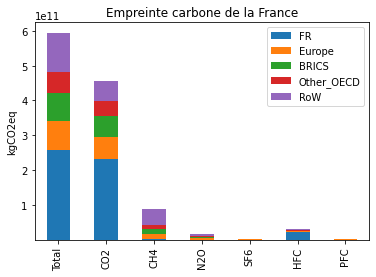

In [7]:
sumonsectors = empreinte_df.sum(axis=1)
total_ges_by_origin = sumonsectors.sum(level=0)
liste_agg_ghg=[]
for ghg in ghg_list:
	liste_agg_ghg.append(sumonsectors.iloc[sumonsectors.index.get_level_values(1)==ghg].sum(level=0))
xs = ['total']+ghg_list
dict_pour_plot = {'Total':total_ges_by_origin,'CO2':liste_agg_ghg[0],
'CH4':liste_agg_ghg[1],'N2O':liste_agg_ghg[2],'SF6':liste_agg_ghg[3],
'HFC':liste_agg_ghg[4],'PFC':liste_agg_ghg[5]}
pour_plot=pd.DataFrame(data=dict_pour_plot,index=reg_list)
pour_plot.transpose().plot.bar(stacked=True)
plt.title("Empreinte carbone de la France")
plt.ylabel("kgCO2eq")
plt.savefig("figures/empreinte_carbone_fr_importation.png")
plt.show()

['CO2', 'CH4', 'N2O', 'SF6', 'HFC', 'PFC']


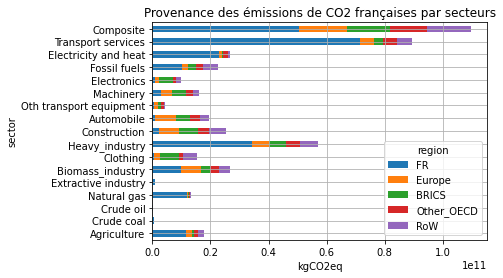

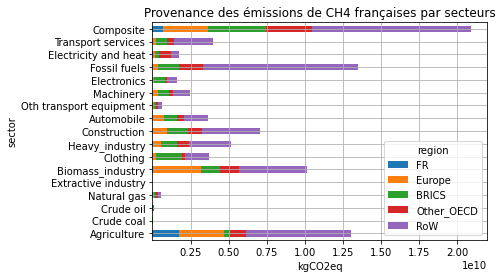

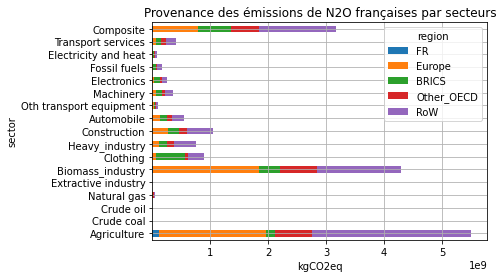

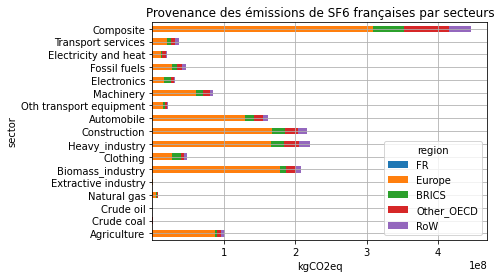

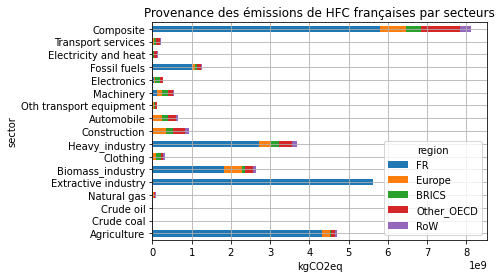

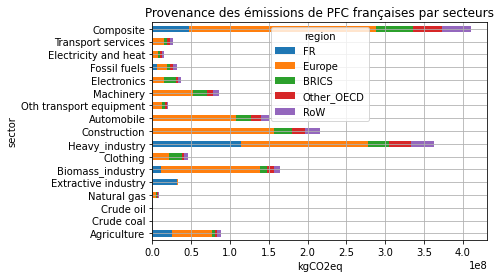

Text(0.5, 1.0, 'Provenance des émissions de GES françaises par secteurs')

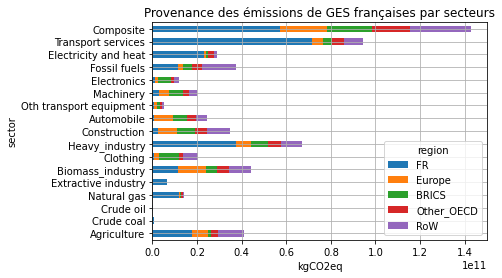

In [93]:
# reference analysis
## ToDo

print(ghg_list)
df_all_ghg = pd.DataFrame(None, index = reference.get_sectors(), columns = reference.get_regions())
df_all_ghg = df_all_ghg.fillna(0)
for ghg in ghg_list:
    df = pd.DataFrame(None, index = reference.get_sectors(), columns = reference.get_regions())
    for reg in reference.get_regions():
        df.loc[:,reg]=empreinte_df.loc[(reg,ghg)]
        df_all_ghg[reg]+=empreinte_df.loc[(reg,ghg)]
    ax=df.plot.barh(stacked=True)
    plt.grid()
    plt.xlabel("kgCO2eq")
    plt.title("Provenance des émissions de "+ghg+" françaises par secteurs")
    #plt.savefig('figures/french_'+ghg+'emissions_provenance_sectors')
    plt.show()
ax=df_all_ghg.plot.barh(stacked=True)
plt.grid()
plt.xlabel("kgCO2eq")
plt.title("Provenance des émissions de GES françaises par secteurs")
#plt.savefig('figures/french_all_ghg_emissions_provenance_sectors')
# whole static comparative analysis
## ToDo

# VISUALIZE

In [9]:
dcba = reference.ghg_emissions_desag.D_cba
dpba = reference.ghg_emissions_desag.D_pba
dimp = reference.ghg_emissions_desag.D_imp
dexp = reference.ghg_emissions_desag.D_exp

In [23]:
#print(dcba)
#empreinte_df = dcba['FR']
production_df = dpba['FR']
production_df
#print(dimp)
#print(dexp)

sector               Agriculture  Crude coal  Crude oil  Natural gas  \
region     stressor                                                    
FR         CO2          7.023067    0.435047   0.218686    10.091820   
           CH4         29.725399    0.000093   2.735859     0.924061   
           N2O         18.360508    0.002808   0.003383     0.004958   
           SF6          0.049439    0.000081   0.000151     0.000413   
           HFC          2.639473    0.004361   0.009134     0.021181   
           PFC          0.015288    0.000028   0.000078     0.000168   
Europe     CO2          2.033753    0.050965   0.020629     0.707086   
           CH4          8.607938    0.000011   0.258076     0.064745   
           N2O          5.316871    0.000329   0.000319     0.000347   
           SF6          0.014317    0.000010   0.000014     0.000029   
           HFC          0.764344    0.000511   0.000862     0.001484   
           PFC          0.004427    0.000003   0.000007     0.000012   
BRICS      CO2          0.477385    0.018047   0.006566     0.210572   
           CH4          2.020550    0.000004   0.082138     0.019281   
           N2O          1.248034    0.000116   0.000102     0.000103   
           SF6          0.003361    0.000003   0.000005     0.000009   
           HFC          0.179415    0.000181   0.000274     0.000442   
           PFC          0.001039    0.000001   0.000002     0.000004   
Other_OECD CO2          1.024810    0.042958   0.020693     0.556341   
           CH4          4.337547    0.000009   0.258882     0.050942   
           N2O          2.679176    0.000277   0.000320     0.000273   
           SF6          0.007214    0.000008   0.000014     0.000023   
           HFC          0.385153    0.000431   0.000864     0.001168   
           PFC          0.002231    0.000003   0.000007     0.000009   
RoW        CO2          0.915375    0.029298   0.014461     0.345645   
           CH4          3.874362    0.000006   0.180910     0.031649   
           N2O          2.393080    0.000189   0.000224     0.000170   
           SF6          0.006444    0.000005   0.000010     0.000014   
           HFC          0.344025    0.000294   0.000604     0.000725   
           PFC          0.001993    0.000002   0.000005     0.000006   

sector               Extractive industry  Biomass_industry  Clothing  \
region     stressor                                                    
FR         CO2                  0.596785          5.986434  0.169323   
           CH4                  0.001532          0.197139  0.002439   
           N2O                  0.003765          0.262944  0.000183   
           SF6                  0.073190          0.021392  0.000139   
           HFC                  3.819792          1.124786  0.007320   
           PFC                  0.021956          0.006636  0.000040   
Europe     CO2                  0.104278          1.541281  0.153256   
           CH4                  0.000268          0.050756  0.002208   
           N2O                  0.000658          0.067698  0.000165   
           SF6                  0.012789          0.005508  0.000125   
           HFC                  0.667442          0.289590  0.006626   
           PFC                  0.003836          0.001708  0.000036   
BRICS      CO2                  0.034646          0.298111  0.026548   
           CH4                  0.000089          0.009817  0.000382   
           N2O                  0.000219          0.013094  0.000029   
           SF6                  0.004249          0.001065  0.000022   
           HFC                  0.221758          0.056012  0.001148   
           PFC                  0.001275          0.000330  0.000006   
Other_OECD CO2                  0.081350          1.108670  0.102872   
           CH4                  0.000209          0.036510  0.001482   
           N2O                  0.000513          0.048696  0.000111   
           SF6                  0.00997

In [22]:
sumonsectors_empreinte = empreinte_df.sum(axis=1)
sumonsectors_production = production_df.sum(axis=1)

region      stressor
FR          CO2         163.740290
            CH4          49.643441
            N2O          19.769230
            SF6           0.307717
            HFC          14.605637
            PFC           0.148641
Europe      CO2          61.207909
            CH4          12.973232
            N2O           5.241745
            SF6           1.222204
            HFC           2.576436
            PFC           0.989413
BRICS       CO2          60.868670
            CH4          14.544871
            N2O           2.425939
            SF6           0.156340
            HFC           1.654210
            PFC           0.195776
Other_OECD  CO2          43.584537
            CH4          11.240798
            N2O           2.384703
            SF6           0.176375
            HFC           2.712304
            PFC           0.135552
RoW         CO2          57.395981
            CH4          46.995684
            N2O           7.451016
            SF6           0.100658

In [37]:
# calculate reference system
reference.calc_all()


# update extension calculations
reference.ghg_emissions_desag = Tools.recal_extensions_per_region(
	reference,
	'ghg_emissions'
)

# init counterfactual(s)
counterfactual = reference.copy()
counterfactual.remove_extension('ghg_emissions_desag')
# read param sets to shock reference system
## ToDo
quantity = 0.8
sector = 'Clothing'
move_out = 'BRICS'
move_in = 'Europe'
# build conterfactual(s) using param sets
## ToDo
counterfactual.Z = Tools.shock(list(reference.get_sectors()),reference.Z,move_out,move_in,sector,quantity)
counterfactual.A = None
counterfactual.x = None
counterfactual.L = None

# calculate counterfactual(s) system
counterfactual.calc_all()

counterfactual.ghg_emissions_desag = Tools.recal_extensions_per_region(
	counterfactual,
	'ghg_emissions'
)



In [43]:
reference.Z==counterfactual.Z

region                               FR                                   \
sector                      Agriculture Crude coal Crude oil Natural gas   
region sector                                                              
FR     Agriculture                 True       True      True        True   
       Crude coal                  True       True      True        True   
       Crude oil                   True       True      True        True   
       Natural gas                 True       True      True        True   
       Extractive industry         True       True      True        True   
...                                 ...        ...       ...         ...   
RoW    Electronics                 True       True      True        True   
       Fossil fuels                True       True      True        True   
       Electricity and heat        True       True      True        True   
       Transport services          True       True      True        True   
       Composite                   True       True      True        True   

region                                                                     \
sector                      Extractive industry Biomass_industry Clothing   
region sector                                                               
FR     Agriculture                         True             True     True   
       Crude coal                          True             True     True   
       Crude oil                           True             True     True   
       Natural gas                         True             True     True   
       Extractive industry                 True             True     True   
...                                         ...              ...      ...   
RoW    Electronics                         True             True     True   
       Fossil fuels                        True             True     True   
       Electricity and heat                True             True     True   
       Transport services                  True             True     True   
       Composite                           True             True     True   

region                                                              ...  \
sector                      Heavy_industry Construction Automobile  ...   
region sector                                                       ...   
FR     Agriculture                    True         True       True  ...   
       Crude coal                     True         True       True  ...   
       Crude oil                      True         True       True  ...   
       Natural gas                    True         True       True  ...   
       Extractive industry            True         True       True  ...   
...                                    ...          ...        ...  ...   
RoW    Electronics                    True         True       True  ...   
       Fossil fuels                   True         True       True  ...   
       Electricity and heat           True         True       True  ...   
       Transport services             True         True       True  ...   
       Composite                      True         True       True  ...   

region                                 RoW                          \
sector                      Heavy_industry Construction Automobile   
region sector                                                        
FR     Agriculture                    True         True       True   
       Crude coal                     True         True       True   
       Crude oil                      True         True       True   
       Natural gas                    True         True       True   
       Extractive industry            True         True       True   
...                                    ...          ...        ...   
RoW    Electronics                    True         True       True   
       Fossil fuels                   True         True       True   
       Electricity and heat        

In [53]:
type_emissions = 'D_cba'

dcba = getattr(reference.ghg_emissions_desag,type_emissions)